In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
from tqdm import tqdm
import lightgbm as lgb
from pykalman import KalmanFilter
from filterpy.kalman import KalmanFilter
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from statsmodels.tsa.arima_model import ARIMA

In [29]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [30]:
df = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df = df.set_index('Ngày')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Ngày,,,,,,,,,,,,,,,,,,,,,
01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [31]:
msv = 2151260835
msv%16 + 1  

4

In [32]:
data = df[['4','5','6']]
data

,4,5,6
Ngày,,,
01/01/2021,964.4,964.4,964.4
01/02/2021,1019.7,1019.7,1019.7
01/03/2021,988.4,988.4,988.4
01/04/2021,1002.0,1002.0,1002.0
01/05/2021,1061.5,1061.5,1061.5
...,...,...,...
27/12/2021,1002.0,1002.0,1002.0
28/12/2021,1002.0,1002.0,1002.0
29/12/2021,1061.5,1061.5,1061.5


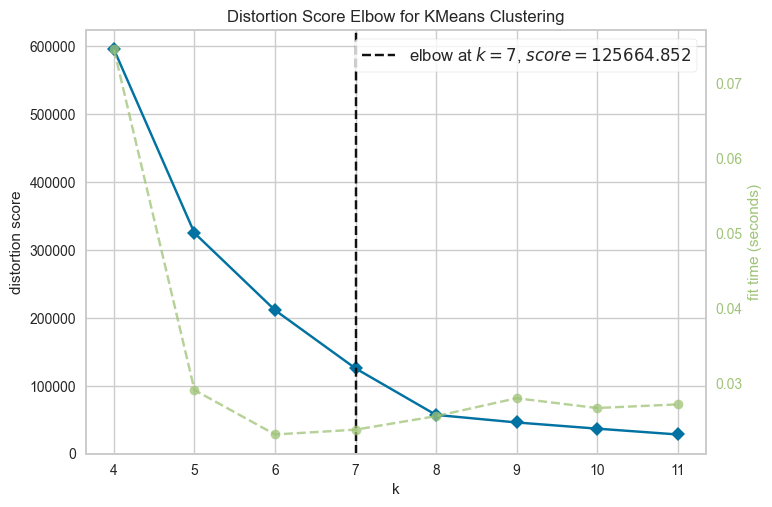

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

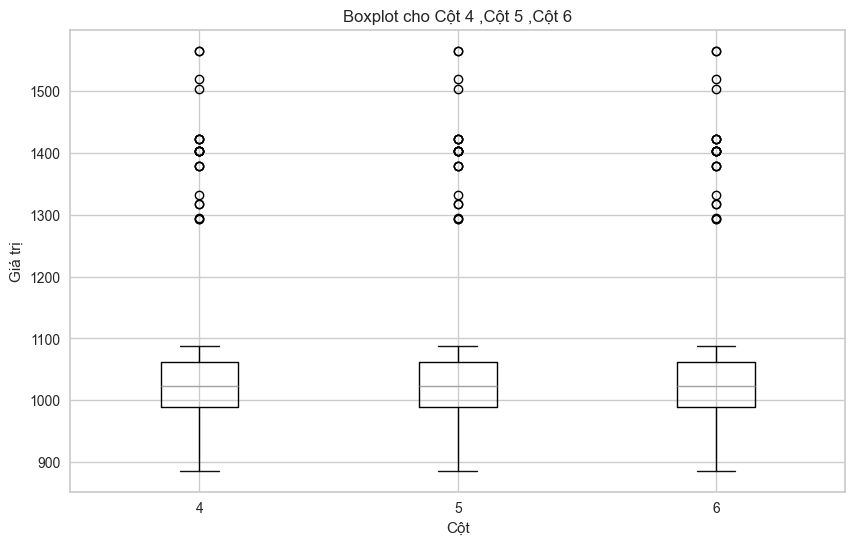

In [34]:
# Tạo boxplot cho cả hai cột
plt.figure(figsize=(10, 6))
data.boxplot()

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot cho Cột 4 ,Cột 5 ,Cột 6')
plt.ylabel('Giá trị')
plt.xlabel('Cột')
plt.show()

<Axes: title={'center': 'Heatmap of Correlation Matrix'}>

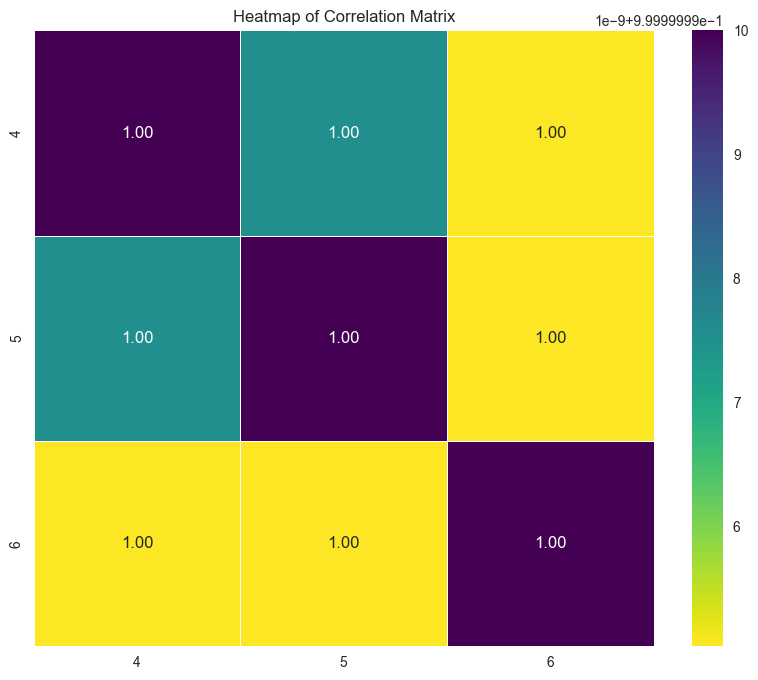

In [35]:
corr_matrix = data.corr()
plt.figure(figsize=(10,8))
plt.title('Heatmap of Correlation Matrix')
sns.heatmap(corr_matrix, annot=True,linewidths=0.5,fmt='.2f', cmap="viridis_r")

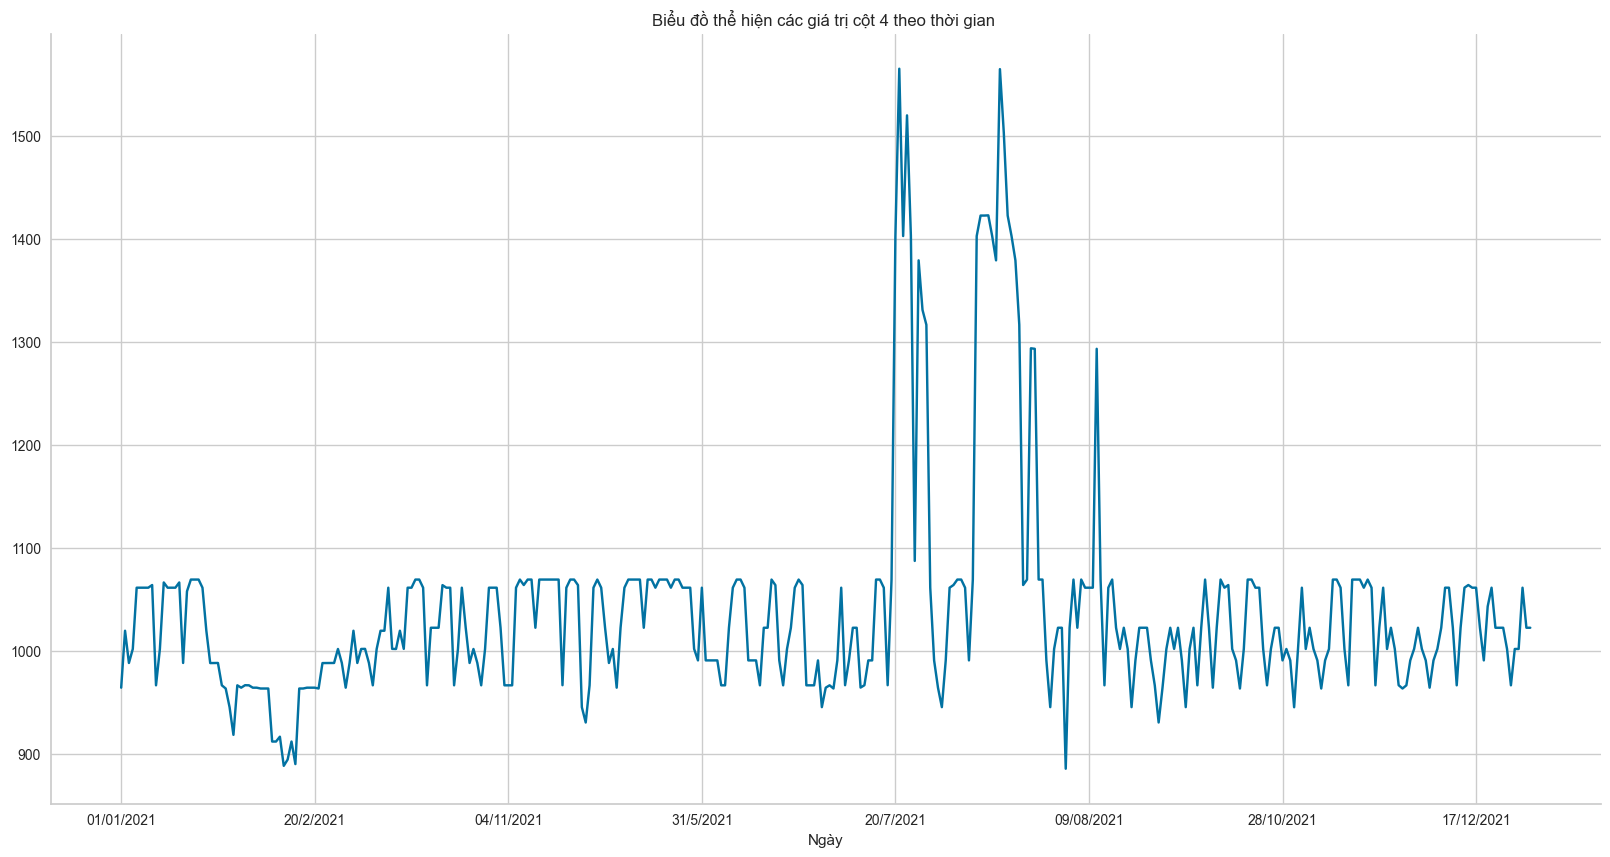

In [36]:
plt.figure(figsize=(20,10))
df['4'].plot(kind='line',figsize=(20,10),title="Biểu đồ thể hiện các giá trị cột 4 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)

### Các Model

Kalman filter

In [37]:
# Tạo ma trận dữ liệu đo lường
z = data[['4', '5', '6']].values.T

# Khởi tạo Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=3)

# Tinh chỉnh ma trận 
kf.F = np.array([[1]])  # Ma trận chuyển đổi trạng thái
kf.H = np.array([[1], [1], [1]])  # Ma trận quan sát (3,1)

# Điều chỉnh ma trận hiệp phương sai
kf.Q = np.array([[0.01]])  # Giảm nhiễu quá trình 
kf.R = np.array([[2, 0, 0],  # Tăng nhiễu đo lường 
                  [0, 2, 0],
                  [0, 0, 2]])  

# Khởi tạo trạng thái ban đầu
kf.x = np.array([[np.mean(z[:, 0])]])
kf.P = np.array([[1]])

# Kalman Filter
x_hat_list = []
for k in range(z.shape[1]):
    kf.predict()
    kf.update(z[:, k])
    x_hat_list.append(kf.x[0, 0])

# Thêm cột ước lượng vào DataFrame
data['kalman_estimate'] = x_hat_list

# Đánh giá hiệu suất
rmse = np.sqrt(mean_squared_error(data[['4', '5', '6']].mean(axis=1), data['kalman_estimate']))
print(f"RMSE của Kalman Filter: {rmse}")

# In DataFrame
print(data)

RMSE của Kalman Filter: 73.82931896311068
                 4       5       6  kalman_estimate
Ngày                                               
01/01/2021   964.4   964.4   964.4       964.400000
01/02/2021  1019.7  1019.7  1019.7       985.509021
01/03/2021   988.4   988.4   988.4       986.330163
01/04/2021  1002.0  1002.0  1002.0       989.937334
01/05/2021  1061.5  1061.5  1061.5      1004.029106
...            ...     ...     ...              ...
27/12/2021  1002.0  1002.0  1002.0      1016.996557
28/12/2021  1002.0  1002.0  1002.0      1015.268895
29/12/2021  1061.5  1061.5  1061.5      1020.594899
30/12/2021  1022.6  1022.6  1022.6      1020.825894
31/12/2021  1022.6  1022.6  1022.6      1021.030278

[365 rows x 4 columns]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19032\3254476713.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['kalman_estimate'] = x_hat_list


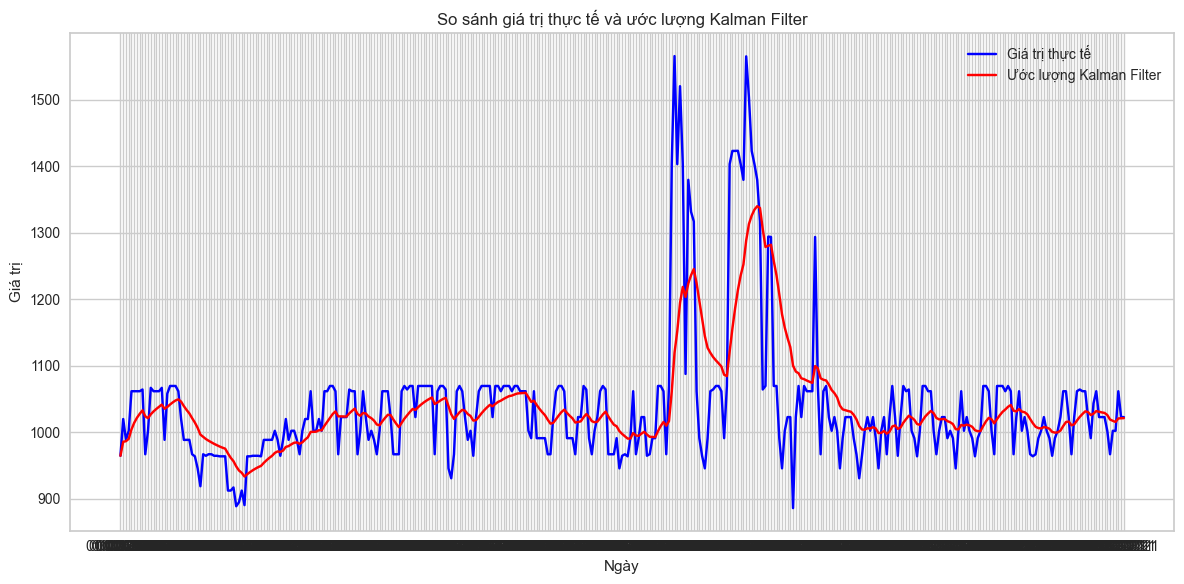

In [38]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[['4', '5', '6']].mean(axis=1), label='Giá trị thực tế', color='blue')
plt.plot(data.index, data['kalman_estimate'], label='Ước lượng Kalman Filter', color='red')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị thực tế và ước lượng Kalman Filter')
plt.legend()
plt.tight_layout()
plt.show()

Hidden Markov 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19032\311802039.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state_sequence'] = state_sequence


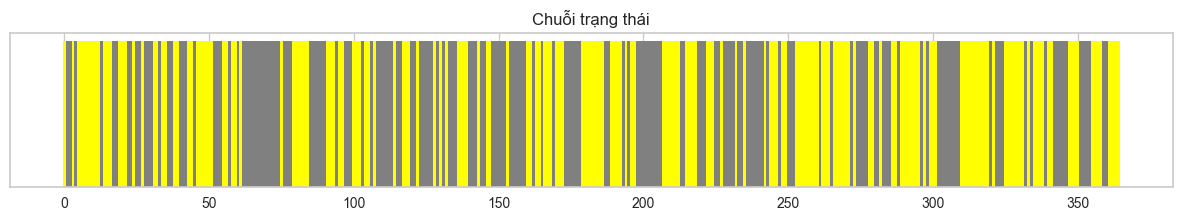

RMSE: 1045.0045533433677
                 4       5       6  kalman_estimate state_sequence
Ngày                                                              
01/01/2021   964.4   964.4   964.4       964.400000              S
01/02/2021  1019.7  1019.7  1019.7       985.509021              C
01/03/2021   988.4   988.4   988.4       986.330163              C
01/04/2021  1002.0  1002.0  1002.0       989.937334              S
01/05/2021  1061.5  1061.5  1061.5      1004.029106              C
...            ...     ...     ...              ...            ...
27/12/2021  1002.0  1002.0  1002.0      1016.996557              C
28/12/2021  1002.0  1002.0  1002.0      1015.268895              S
29/12/2021  1061.5  1061.5  1061.5      1020.594899              S
30/12/2021  1022.6  1022.6  1022.6      1020.825894              S
31/12/2021  1022.6  1022.6  1022.6      1021.030278              S

[365 rows x 5 columns]


In [40]:
# Định nghĩa ma trận chuyển đổi trạng thái
transmat = np.array([[0.7, 0.3], 
                     [0.4, 0.6]])  # Xác suất chuyển đổi ví dụ

# Định nghĩa các trạng thái
states = ['S', 'C']  

# Xác suất trạng thái ban đầu
initial_probs = np.array([0.6, 0.4])  

def markov_chain(transmat, initial_probs, n):
    # Hàm sinh chuỗi trạng thái bằng Markov Chain
    states_sequence = []
    current_state = np.random.choice(states, p=initial_probs)
    states_sequence.append(current_state)
    
    for _ in range(n - 1):
        if current_state == 'S':
            current_state = np.random.choice(states, p=transmat[0])
        else:
            current_state = np.random.choice(states, p=transmat[1])
        states_sequence.append(current_state)
    
    return states_sequence

# Sinh chuỗi trạng thái
state_sequence = markov_chain(transmat, initial_probs, 365)

# Chuyển đổi chuỗi trạng thái sang giá trị số để so sánh
state_numerical = [1 if state == 'S' else 0 for state in state_sequence]

# Thêm chuỗi trạng thái vào DataFrame
data['state_sequence'] = state_sequence

# Hiển thị chuỗi trạng thái
state2color = {'S': 'yellow', 'C': 'grey'}
colors = [state2color[state] for state in state_sequence]
plt.figure(figsize=(15, 2))
plt.bar(range(len(state_sequence)), [1] * len(state_sequence), color=colors, width=1.0)
plt.yticks([])
plt.title('Chuỗi trạng thái')
plt.show()

# Tính trung bình của các cột '4', '5', và '6' để đánh giá
mean_measurements = data[['4', '5', '6']].mean(axis=1)

# Đánh giá hiệu suất bằng RMSE
rmse = np.sqrt(mean_squared_error(mean_measurements, state_numerical))
print(f"RMSE: {rmse}")

# In DataFrame với chuỗi trạng thái
print(data)



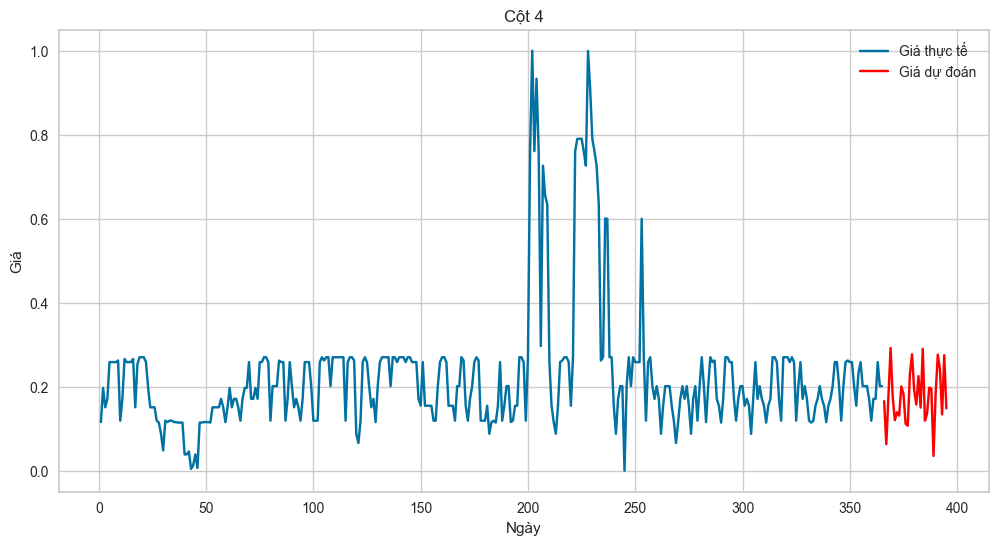

In [49]:
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Đọc dữ liệu
# Chuẩn bị dữ liệu
df['Date'] = [x for x in range(1, 366)]
df['Price_4'] = (df['4'] - df['4'].min()) / (df['4'].max() - df['4'].min())
# Tạo HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# Huấn luyện HMM
model.fit(df['Price_4'].values.reshape(-1, 1))

# Dự đoán giá cho 30 ngày tiếp theo
last_day = df['Date'].max()
predicted_days = np.arange(last_day + 1, last_day + 31)
predicted_states = model.predict(df['Price_4'].values.reshape(-1, 1))
predicted_prices = []

# Khởi tạo giá trị đầu tiên cho dự đoán
current_price = df['Price_4'].values[-1]

# Sử dụng mô hình để dự đoán giá dựa trên trạng thái ẩn
for i in range(30):
    # Dự đoán trạng thái tiếp theo
    current_state = model.predict([[current_price]])[0]
    # Lấy mẫu từ phân phối Gaussian của trạng thái hiện tại
    predicted_price = np.random.normal(model.means_[current_state][0], np.sqrt(model.covars_[current_state][0][0]))
    predicted_prices.append(predicted_price)
    # Cập nhật giá hiện tại cho lần dự đoán tiếp theo
    current_price = predicted_price

# Chuyển đổi giá dự đoán về khoảng giá gốc
predicted_prices = np.array(predicted_prices) * (df['Price_4'].max() - df['Price_4'].min()) + df['Price_4'].min()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price_4'], label='Giá thực tế')
plt.plot(predicted_days, predicted_prices, color='red', label='Giá dự đoán')
plt.title('Cột 4')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()

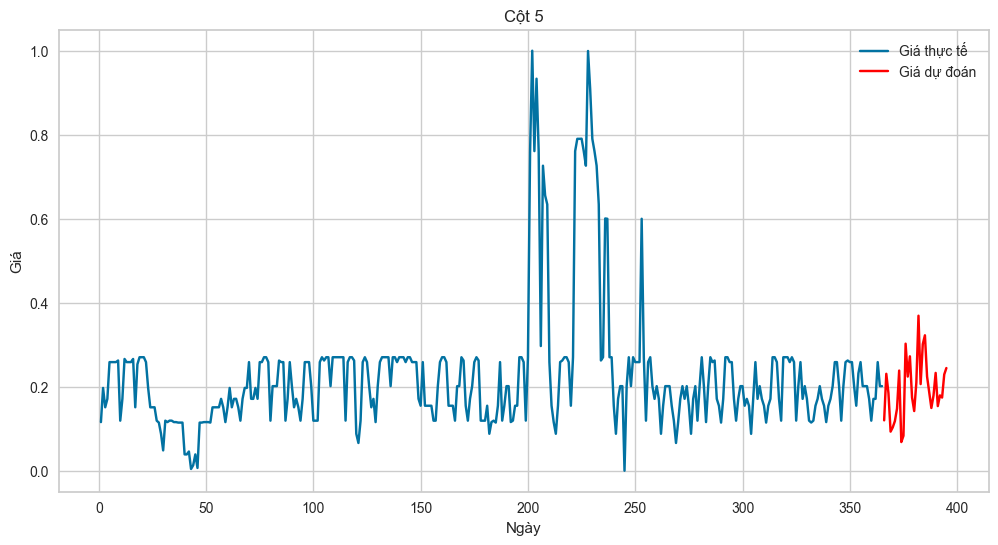

In [50]:
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Đọc dữ liệu
# Chuẩn bị dữ liệu
df['Date'] = [x for x in range(1, 366)]
df['Price_5'] = (df['5'] - df['5'].min()) / (df['5'].max() - df['5'].min())
# Tạo HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# Huấn luyện HMM
model.fit(df['Price_5'].values.reshape(-1, 1))

# Dự đoán giá cho 30 ngày tiếp theo
last_day = df['Date'].max()
predicted_days = np.arange(last_day + 1, last_day + 31)
predicted_states = model.predict(df['Price_5'].values.reshape(-1, 1))
predicted_prices = []

# Khởi tạo giá trị đầu tiên cho dự đoán
current_price = df['Price_5'].values[-1]

# Sử dụng mô hình để dự đoán giá dựa trên trạng thái ẩn
for i in range(30):
    # Dự đoán trạng thái tiếp theo
    current_state = model.predict([[current_price]])[0]
    # Lấy mẫu từ phân phối Gaussian của trạng thái hiện tại
    predicted_price = np.random.normal(model.means_[current_state][0], np.sqrt(model.covars_[current_state][0][0]))
    predicted_prices.append(predicted_price)
    # Cập nhật giá hiện tại cho lần dự đoán tiếp theo
    current_price = predicted_price

# Chuyển đổi giá dự đoán về khoảng giá gốc
predicted_prices = np.array(predicted_prices) * (df['Price_5'].max() - df['Price_5'].min()) + df['Price_5'].min()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price_5'], label='Giá thực tế')
plt.plot(predicted_days, predicted_prices, color='red', label='Giá dự đoán')
plt.title('Cột 5')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()

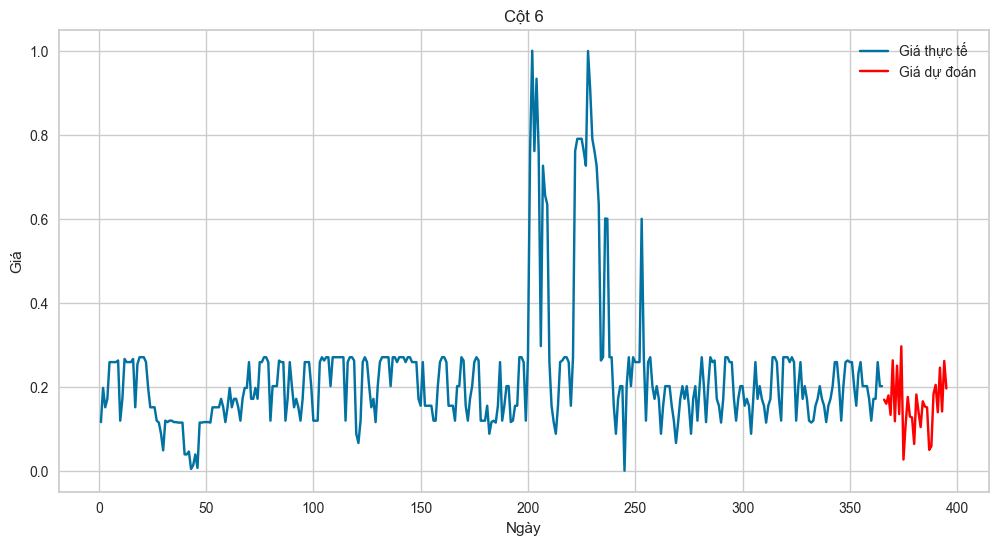

In [51]:
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt

# Đọc dữ liệu
# Chuẩn bị dữ liệu
df['Date'] = [x for x in range(1, 366)]
df['Price_6'] = (df['6'] - df['6'].min()) / (df['6'].max() - df['6'].min())
# Tạo HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# Huấn luyện HMM
model.fit(df['Price_6'].values.reshape(-1, 1))

# Dự đoán giá cho 30 ngày tiếp theo
last_day = df['Date'].max()
predicted_days = np.arange(last_day + 1, last_day + 31)
predicted_states = model.predict(df['Price_5'].values.reshape(-1, 1))
predicted_prices = []

# Khởi tạo giá trị đầu tiên cho dự đoán
current_price = df['Price_6'].values[-1]

# Sử dụng mô hình để dự đoán giá dựa trên trạng thái ẩn
for i in range(30):
    # Dự đoán trạng thái tiếp theo
    current_state = model.predict([[current_price]])[0]
    # Lấy mẫu từ phân phối Gaussian của trạng thái hiện tại
    predicted_price = np.random.normal(model.means_[current_state][0], np.sqrt(model.covars_[current_state][0][0]))
    predicted_prices.append(predicted_price)
    # Cập nhật giá hiện tại cho lần dự đoán tiếp theo
    current_price = predicted_price

# Chuyển đổi giá dự đoán về khoảng giá gốc
predicted_prices = np.array(predicted_prices) * (df['Price_6'].max() - df['Price_6'].min()) + df['Price_6'].min()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price_6'], label='Giá thực tế')
plt.plot(predicted_days, predicted_prices, color='red', label='Giá dự đoán')
plt.title('Cột 6')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()